In [2]:
import pymc3 as pm
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

In [3]:
tau_m = 0.01
J = -1 * tau_m

def approx_q(nu_bar,alpha_0,tau_I):
    
    #tau_I = paras['tau_I']
    #alpha_0 = paras['alpha_0']
    #nu_bar = paras['nu_bar']
    
    nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )
    tau_q = 2. * (tau_I + tau_m)
    q_0 = alpha_0**2 / J**2.
        
    eps = tau_q * ( nu_bar**2 + q_0 ) / ( nu_bar + 2. * tau_q * (nu_bar**2 + q_0) )
    
    q = 1. / np.sqrt( 1. + 2 * tau_q * ( nu_bar + q_0 / nu_bar ) ) * \
        ( 1. + tau_q * ( nu_bar + q_0 / nu_bar ))**( 1. - eps ) * \
        nu_max**( 2. * eps ) * nu_bar**( 2. - 2. * eps )
    
    return q

def logp_raw(nu_bar,alpha_0,tau_I,NU):
    #check, whether logl is alright

    nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )
    print(nu_max)

    q = approx_q({'nu_bar': nu_bar, 'alpha_0': alpha_0, 'tau_I': tau_I})
    
    sigma_I = np.sqrt(J**2 * nu_bar / ( 2 * tau_I ))
    sigma_V = np.sqrt(sigma_I**2 * tau_I / (tau_I + tau_m))
    alpha = np.sqrt(J**2 * q + alpha_0**2)

    print(q,alpha,sigma_V)

    gamma = sigma_V / alpha

    I_0 = np.sqrt( -( alpha**2 + sigma_V**2 ) * np.log( ( nu_bar / nu_max )**2 * ( alpha**2/sigma_V**2 + 1 ) ) )
    delta = I_0 / alpha
    
    p = gamma / ( nu_max * np.sqrt( -np.pi * np.log( NU / nu_max ) ) ) * \
        np.exp( - delta**2/2.) * ( NU / nu_max )**(gamma**2 - 1) * \
        np.cosh( gamma * delta * np.sqrt( -2 * np.log( NU / nu_max) ) )

    logp = np.log( nu_max / gamma * np.sqrt( -np.pi * np.log( NU / nu_max ) ) ) - delta**2 / 2 + \
        ( gamma**2 - 1 ) * np.log( NU / nu_max ) + \
        np.log( np.cosh( gamma * delta * np.sqrt( -2 * np.log( NU / nu_max ) ) ) )

    return p, logp

In [4]:
## create data for inference, or read from model
%cd ..
from create_measures import *
res = create_measures(L=1,S=[1,2],rerun=True)
print(res)

/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme
{'rates': masked_array(
  data=[[4.76789967e-02, 1.57508083e-02, 2.81040966e+00, 1.73838186e+00],
        [4.78217170e-01, 5.34778258e-01, 9.99887519e-03, 2.74298822e-01],
        [1.32798877e+00, 2.21753579e-01, 1.33577630e-02, 2.22514507e+00],
        [3.73122239e+00, 4.35546711e-01, 9.78425414e-02, 3.74757465e-01],
        [6.24448129e-01, 1.30963744e+00, 1.49102266e-02, 4.07953503e-02],
        [5.89465599e-01, 4.58607649e-01, 6.12361662e-02, 5.32184113e-01],
        [1.54829748e+00, 6.89298415e-02, 4.34055316e-01, 2.90906706e-01],
        [1.48512562e-01, 4.79150164e+00, 3.11358057e-01, 2.19496156e+00],
        [7.35807575e-01, 1.41909931e-01, 3.43967501e+00, 7.81197624e-02],
        [2.10194536e-01, 1.54213491e-01, 1.84697557e-01, 5.19974171e-01],
        [2.50675446e-01, 6.58764334e-02, 1.21559250e-01, 1.11097570e-01],
        [3.72568940e+00, 3.71141555e-02, 4.18599912e-01, 7.76599568e-01],
        [2.16524737e+00, 5.3181

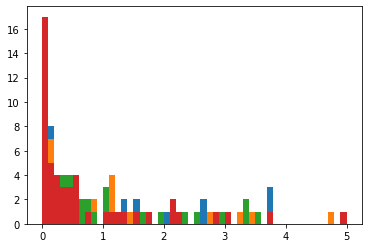

In [5]:
NU = np.squeeze(res['rates_T'])

n = NU.shape[1] # number of distinct tuples of (animals, hemispheres, layers)
obs_nu_bar = np.mean(NU,axis=0)   # should have 

for i in range(n):
    plt.hist(NU[:,i],np.linspace(0,5,51))
    
plt.show()

In [22]:
np.min(NU)

0.0016666666666666668

In [24]:
probably: change observations and likelihood to flattened array; provide indices to mouse

with pm.Model() as model:
    # replace normals with student-t distributions
    mu_alpha_0 = pm.HalfStudentT('mu_alpha_0',0.05,1.);
    sigma_alpha_0 = pm.HalfStudentT('sigma_alpha_0',0.02,1.);
    
    alpha_0 = pm.HalfStudentT('alpha_0',mu_alpha_0,sigma_alpha_0,shape=n);
    
    
    nu_bar = pm.Normal('nu_bar',obs_nu_bar,0.5,shape=n);
    
    
    mu_tau_I = pm.Normal('mu_tau_I',0.01,0.002);
    sigma_tau_I = pm.HalfStudentT('sigma_tau_I',0.02,1.);
    
    tau_I = pm.HalfStudentT('tau_I',mu_tau_I,sigma_tau_I,shape=n);
    
    
    def logp(NU):
        #check, whether logl is alright
        #print(nu_bar,alpha_0,tau_I)
        
        nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )
        
        q = approx_q(nu_bar,alpha_0,tau_I)
        
        sigma_I = np.sqrt(J**2 * nu_bar / ( 2 * tau_I ))
        sigma_V = np.sqrt(sigma_I**2 * tau_I / (tau_I + tau_m))
        alpha = np.sqrt(J**2 * q + alpha_0**2)
        
        gamma = sigma_V / alpha
        
        I_0 = np.sqrt( -( alpha**2 + sigma_V**2 ) * np.log( ( nu_bar / nu_max )**2 * ( alpha**2/sigma_V**2 + 1 ) ) )
        delta = I_0 / alpha
        
        # p = gamma / ( nu_max * np.sqrt( -np.pi * np.log( NU / nu_max ) ) ) * \
        #    np.exp( - delta**2/2.) * ( NU / nu_max )**(gamma**2 - 1) * \
        #    np.cosh( gamma * delta * np.sqrt( -2 * np.log( NU / nu_max) ) )
        
        logp = np.log( nu_max / gamma * np.sqrt( -np.pi * np.log( NU / nu_max ) ) ) - delta**2 / 2 + \
            ( gamma**2 - 1 ) * np.log( NU / nu_max ) + \
            np.log( np.cosh( gamma * delta * np.sqrt( -2 * np.log( NU / nu_max ) ) ) )
       
        return logp
    
    likelihood = pm.DensityDist('logp',logp,observed=NU)
                   
    trace = pm.sample(return_inferencedata=True)

/home/wollex/.local/share/virtualenvs/Programme-MdXiJbEw/lib/python3.8/site-packages/pymc3/distributions/continuous.py:138: UserWarning: The variable specified for nu has negative support for HalfStudentT, likely making it unsuitable for this parameter.
  warnings.warn(msg)
/tmp/ipykernel_50951/3542763102.py:32: RuntimeWarning: invalid value encountered in sqrt
  I_0 = np.sqrt( -( alpha**2 + sigma_V**2 ) * np.log( ( nu_bar / nu_max )**2 * ( alpha**2/sigma_V**2 + 1 ) ) )
/tmp/ipykernel_50951/3542763102.py:39: RuntimeWarning: invalid value encountered in sqrt
  logp = np.log( nu_max / gamma * np.sqrt( -np.pi * np.log( NU / nu_max ) ) ) - delta**2 / 2 + \
/tmp/ipykernel_50951/3542763102.py:41: RuntimeWarning: invalid value encountered in sqrt
  np.log( np.cosh( gamma * delta * np.sqrt( -2 * np.log( NU / nu_max ) ) ) )


nu_bar ~ Normal alpha_0 ~ HalfStudentT tau_I ~ HalfStudentT
nu_bar ~ Normal alpha_0 ~ HalfStudentT tau_I ~ HalfStudentT
nu_bar ~ Normal alpha_0 ~ HalfStudentT tau_I ~ HalfStudentT


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mu_alpha_0_log__': array(0.), 'sigma_alpha_0_log__': array(0.), 'alpha_0_log__': array([0., 0., 0., 0.]), 'nu_bar': array([1.0933    , 1.1591    , 1.01966667, 1.09973333]), 'mu_tau_I': array(0.01), 'sigma_tau_I_log__': array(0.), 'tau_I_log__': array([0., 0., 0., 0.])}

Initial evaluation results:
mu_alpha_0_log__       -3.13
sigma_alpha_0_log__    -3.97
alpha_0_log__          -4.58
nu_bar                 -0.90
mu_tau_I                5.30
sigma_tau_I_log__      -3.97
tau_I_log__           -18.56
logp                     NaN
Name: Log-probability of test_point, dtype: float64

array([[<AxesSubplot:title={'center':'mu_alpha_0'}>,
        <AxesSubplot:title={'center':'sigma_alpha_0'}>,
        <AxesSubplot:title={'center':'alpha_0\n0'}>,
        <AxesSubplot:title={'center':'alpha_0\n1'}>],
       [<AxesSubplot:title={'center':'alpha_0\n2'}>,
        <AxesSubplot:title={'center':'alpha_0\n3'}>,
        <AxesSubplot:title={'center':'nu_bar\n0'}>,
        <AxesSubplot:title={'center':'nu_bar\n1'}>],
       [<AxesSubplot:title={'center':'nu_bar\n2'}>,
        <AxesSubplot:title={'center':'nu_bar\n3'}>,
        <AxesSubplot:title={'center':'mu_tau_I'}>,
        <AxesSubplot:title={'center':'sigma_tau_I'}>],
       [<AxesSubplot:title={'center':'tau_I\n0'}>,
        <AxesSubplot:title={'center':'tau_I\n1'}>,
        <AxesSubplot:title={'center':'tau_I\n2'}>,
        <AxesSubplot:title={'center':'tau_I\n3'}>]], dtype=object)

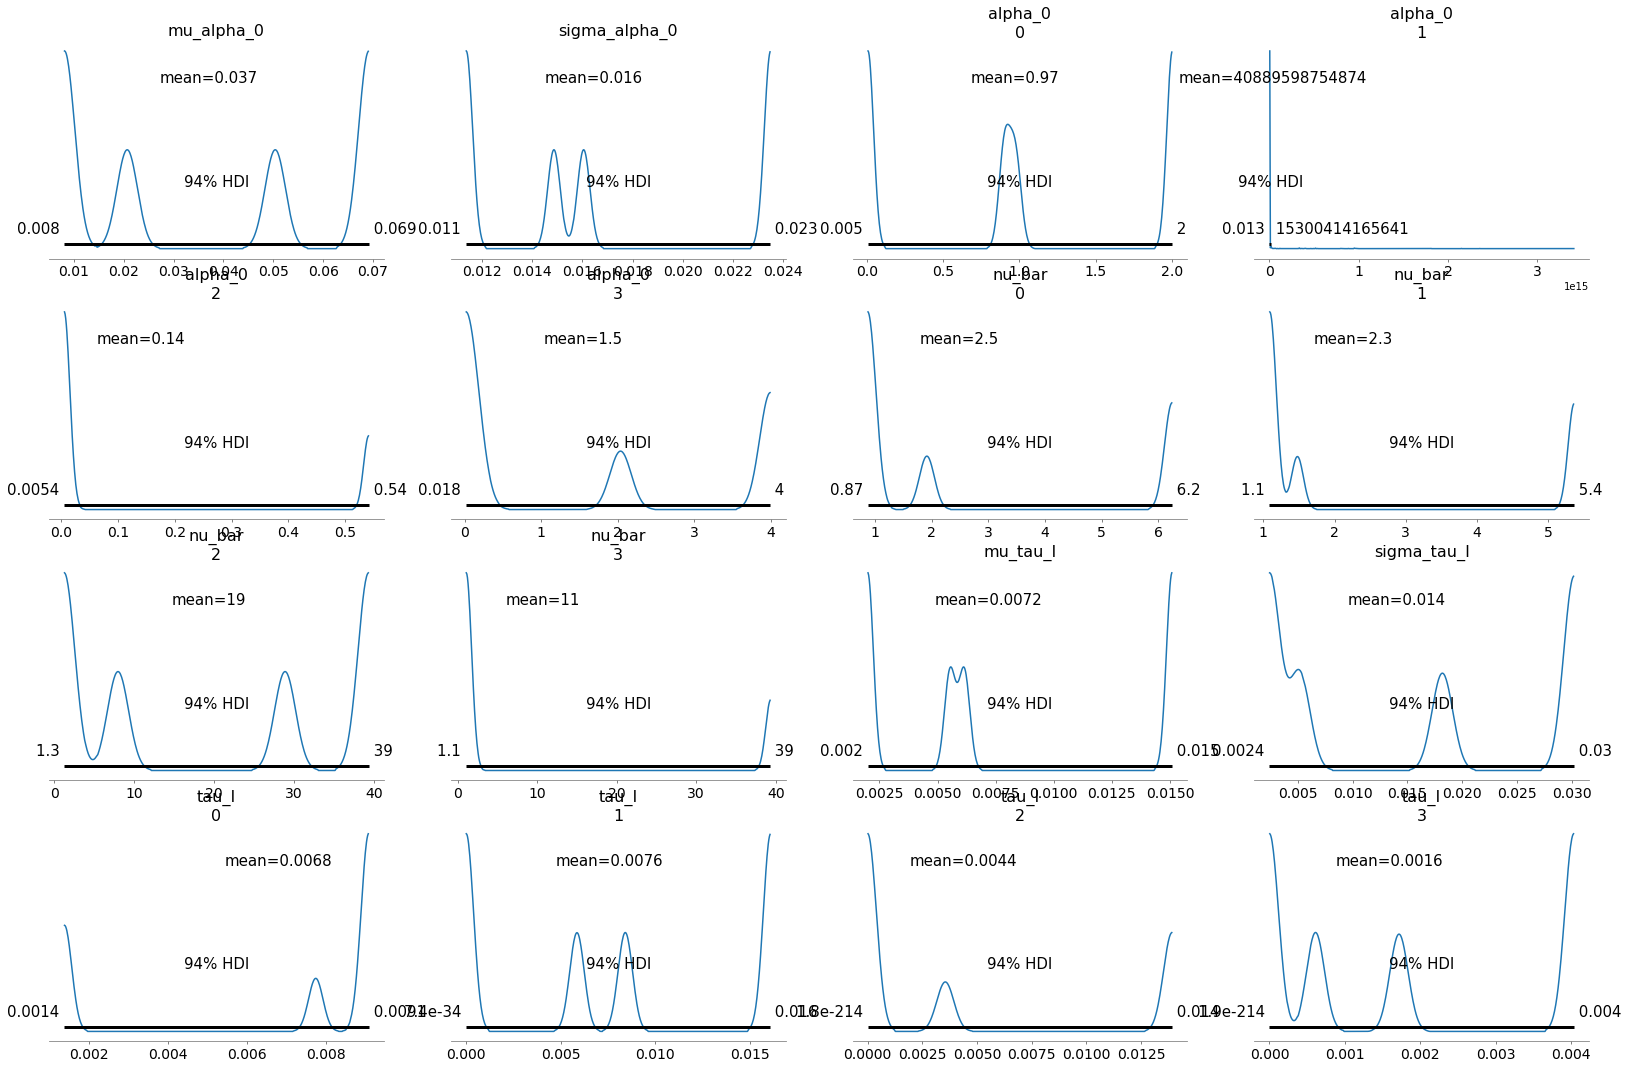

In [16]:
az.plot_posterior(trace)

In [ ]:
nu = np.linspace(0.,2.,101)
plt.plot(nu,approx_q({'tau_I': 0.005, 'alpha_0': 0.04, 'nu_bar': nu}))
plt.plot(nu,nu**2,'r--')
plt.show()

In [ ]:
nu = np.linspace(0.1,10.,100)
p, log = logp_raw(2.,0.02,0.005,nu)
plt.plot(nu,p)
